In [1]:
# ===========================================
# Task 2: SVM Classification - Iris Dataset 
# Author: Houssam
# Tools: Python, scikit-learn, imbalanced-learn, pandas, matplotlib, joblib
# ===========================================
!pip install --upgrade scikit-learn imbalanced-learn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 80.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 

In [2]:
# ===== 1. Load Iris Dataset from CSV =====
data_path = "/kaggle/input/iris-dataset/iris-dataset/iris.csv"  
df = pd.read_csv(data_path)


In [3]:
# ===== 2. Filter for Versicolor & Virginica Only =====
df = df[df["species"].isin(["versicolor", "virginica"])]
X = df.drop("species", axis=1).values
y = df["species"].map(lambda s: 0 if s == "versicolor" else 1).values

In [4]:
# ===== 3. Train/Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===== 3.1 Apply SMOTE =====
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [5]:
# ===== 4. Feature Scaling =====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# ===== 5. Train Models =====
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train, y_train)

svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [7]:
# ===== 6. Save Models & Scaler =====
os.makedirs("saved_models", exist_ok=True)
joblib.dump(svm_linear, "saved_models/svm_linear.pkl")
joblib.dump(svm_rbf, "saved_models/svm_rbf.pkl")
joblib.dump(scaler, "saved_models/scaler.pkl")
print("✅ Models and scaler saved in 'saved_models/' folder")

✅ Models and scaler saved in 'saved_models/' folder


In [8]:
# ===== 7. Predictions =====
y_pred_linear = svm_linear.predict(X_test)
y_prob_linear = svm_linear.predict_proba(X_test)

y_pred_rbf = svm_rbf.predict(X_test)
y_prob_rbf = svm_rbf.predict_proba(X_test)


# ===== Function to Save and Display Confusion Matrix =====
def save_confusion_matrix(y_true, y_pred, classes, folder, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    save_path = os.path.join(folder, f"{model_name}_confusion_matrix.png")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()


In [9]:
# ===== Helper to Save Outputs =====
def save_results(model_name, model, X_train, y_train, X_test, y_test, y_pred, y_prob):
    folder = f"{model_name}_results"
    os.makedirs(folder, exist_ok=True)
    classes = ["Versicolor", "Virginica"]
    
    # Metrics
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob[:, 1])
    clf_report = classification_report(y_test, y_pred, target_names=classes)

    # Save metrics
    with open(os.path.join(folder, "metrics.txt"), "w") as f:
        f.write(f"Train Accuracy: {train_acc:.4f}\n")
        f.write(f"Test Accuracy: {test_acc:.4f}\n")
        f.write(f"AUC: {auc:.4f}\n")

    # Save classification report
    with open(os.path.join(folder, "classification_report.txt"), "w") as f:
        f.write(clf_report)

    # Print in console
    print(f"\n=== {model_name.upper()} MODEL ===")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:\n", clf_report)

    # Save Confusion Matrix as Image
    save_confusion_matrix(y_test, y_pred, classes, folder, model_name)

    return folder



=== LINEAR MODEL ===
Train Accuracy: 0.9750
Test Accuracy: 0.9000
AUC: 1.0000

Classification Report:
               precision    recall  f1-score   support

  Versicolor       1.00      0.80      0.89        10
   Virginica       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



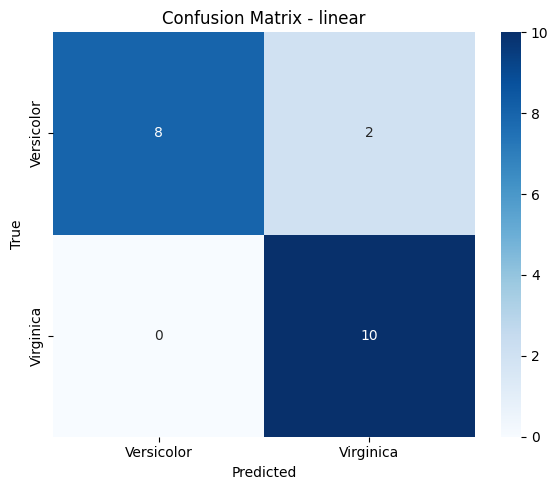


=== RBF MODEL ===
Train Accuracy: 0.9625
Test Accuracy: 0.9000
AUC: 0.9700

Classification Report:
               precision    recall  f1-score   support

  Versicolor       0.83      1.00      0.91        10
   Virginica       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



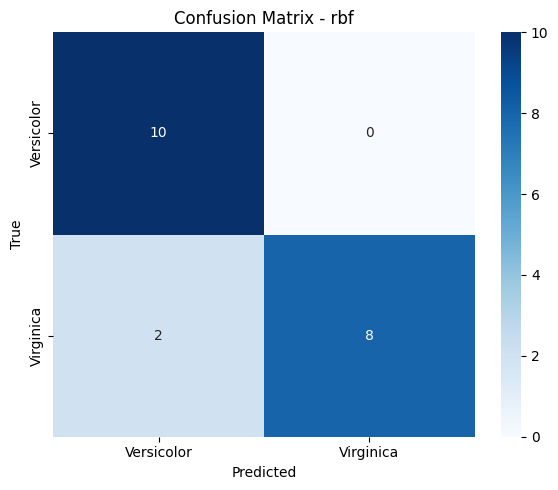

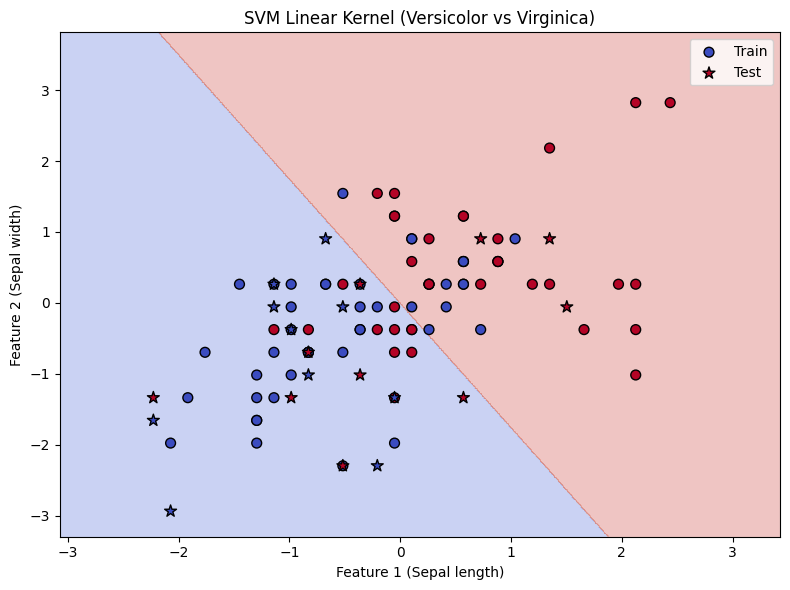

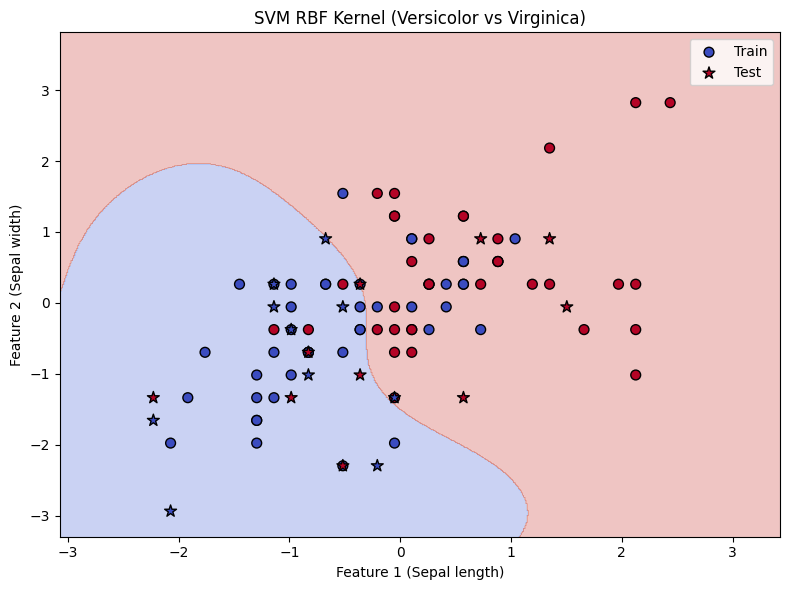


✅ All results, reports, plots, and models saved successfully!


In [10]:
# ===== Save Results =====
linear_folder = save_results("linear", svm_linear, X_train, y_train, X_test, y_test, y_pred_linear, y_prob_linear)
rbf_folder = save_results("rbf", svm_rbf, X_train, y_train, X_test, y_test, y_pred_rbf, y_prob_rbf)


# ===== Visualization on 2 Features =====
X_train_2 = X_train[:, :2]
X_test_2 = X_test[:, :2]
svm_linear_2 = SVC(kernel='linear', probability=True, random_state=42).fit(X_train_2, y_train)
svm_rbf_2 = SVC(kernel='rbf', probability=True, random_state=42).fit(X_train_2, y_train)

def plot_decision_boundary(model, X, y, title, save_path, X_test=None, y_test=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k', cmap=plt.cm.coolwarm, label="Train")
    if X_test is not None:
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=80, edgecolors='k',
                    cmap=plt.cm.coolwarm, marker='*', label="Test")

    plt.title(title)
    plt.xlabel("Feature 1 (Sepal length)")
    plt.ylabel("Feature 2 (Sepal width)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

plot_decision_boundary(svm_linear_2, X_train_2, y_train,
                       "SVM Linear Kernel (Versicolor vs Virginica)",
                       os.path.join(linear_folder, "decision_boundary.png"), 
                       X_test_2, y_test)

plot_decision_boundary(svm_rbf_2, X_train_2, y_train,
                       "SVM RBF Kernel (Versicolor vs Virginica)",
                       os.path.join(rbf_folder, "decision_boundary.png"),
                       X_test_2, y_test)

print("\n✅ All results, reports, plots, and models saved successfully!")
